# Semantic Segmentation


1.Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>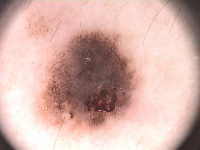</td><td>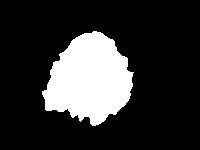</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем сегментировать их.

In [ ]:
! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

--2022-11-15 16:18:29--  https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6030:18::a27d:5012
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/k88qukc20ljnbuo/PH2Dataset.rar [following]
--2022-11-15 16:18:29--  https://www.dropbox.com/s/raw/k88qukc20ljnbuo/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccb39bb45004d002512d17c152d.dl.dropboxusercontent.com/cd/0/inline/Bwwz_F3l8hwzkJ9zjQoV1_2uimKDIMQx2DcR0iDNrd-n5ESOGTWnq9r7wUhnb2GFRZfdgUbVI43nOpCc5c60UNDX1SkBLJjpMupT1K7a_uhsSBO3G10Uz27PePZ_RsiL8jcSAxh6GiwWfUQ35datBG_NaZ0Kzd-6Pqt9fZMBKslmBQ/file# [following]
--2022-11-15 16:18:30--  https://uccb39bb45004d002512d17c152d.dl.dropboxusercontent.com/cd/0/inline/Bwwz_F3l8hwzkJ9zjQoV1_2uimKDIMQx2DcR0iDNrd-n5ESOGTWnq9r7wUhnb2GFRZfdgUb

In [ ]:
#! sudo apt-get install unrar

In [ ]:
! unrar x PH2Dataset.rar


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from PH2Dataset.rar

Creating    PH2Dataset                                                OK
Extracting  PH2Dataset/PH2_dataset.txt                                     0%  OK 
Extracting  PH2Dataset/PH2_dataset.xlsx                                    0%  OK 
Extracting  PH2Dataset/Readme.txt                                          0%  OK 
Creating    PH2Dataset/PH2 Dataset images                             OK
Creating    PH2Dataset/PH2 Dataset images/IMD002                      OK
Creating    PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image  OK
Extracting  PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp       0%  OK 
Creating    PH2Dataset/PH2 Dataset images/IMD002/IMD002_lesion        OK
Extracting  PH2Dataset/PH2 Dataset images/IMD002/IMD002_lesion/IMD002_lesion.bmp       0%  OK 
Creating    PH2Dataset/PH2 Dataset images

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета предлагается использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize) можно использовать для изменения размера изображений. 
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

In [ ]:
!nvidia-smi

Thu Jun 30 15:46:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

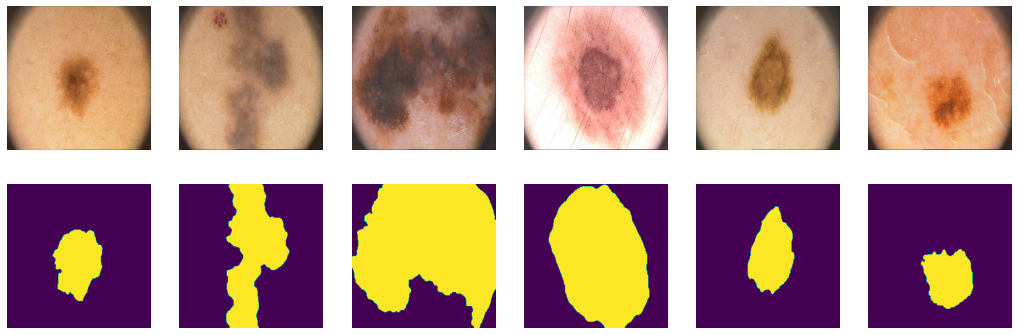

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:

-----------------------------------------------------------------------------------------

# SegNet 

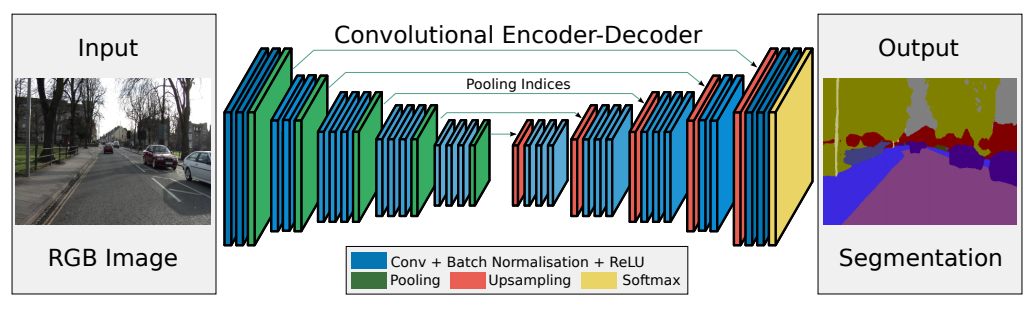

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.pool0 = nn.MaxPool2d((2, 2))  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d((2, 2)) # 128 -> 64
        self.enc_conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d((2, 2)) # 64 -> 32
        self.enc_conv3 =nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d((2, 2)) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(16, 16, kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2) # 16 -> 32
        self.dec_conv0 = nn.Conv2d(16, 16, kernel_size=3, padding=1) 
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(8, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(b)))
        d1 = F.relu(self.dec_conv1(self.upsample1(d0)))
        d2 = F.relu(self.dec_conv2(self.upsample2(d1)))
        d3 = self.dec_conv3(self.upsample3(d2))  # no activation
        return d3

In [ ]:
# class SegNet(nn.Module):
#     def __init__(self):
#         super().__init__()

#         # encoder (downsampling)
#         self.enc_conv0 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
#         self.pool0 = nn.MaxPool2d((2, 2))  # 256 -> 128
#         self.enc_conv1 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
#         self.pool1 = nn.MaxPool2d((2, 2)) # 128 -> 64
#         self.enc_conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
#         self.pool2 = nn.MaxPool2d((2, 2)) # 64 -> 32
#         self.enc_conv3 =nn.Conv2d(16, 16, kernel_size=3, padding=1)
#         self.pool3 = nn.MaxPool2d((2, 2)) # 32 -> 16

#         # bottleneck
#         self.bottleneck_conv = nn.Conv2d(16, 16, kernel_size=1)

#         # decoder (upsampling)
#         self.upsample0 = nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1) # 16 -> 32
# #         self.dec_conv0 = nn.Conv2d(16, 16, kernel_size=3, padding=1) 
#         self.upsample1 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1)
# #         self.dec_conv1 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
#         self.upsample2 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2, padding=1)
# #         self.dec_conv2 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
#         self.upsample3 = nn.ConvTranspose2d(8, 1, kernel_size=3, stride=2, padding=1)
# #         self.dec_conv3 = nn.Conv2d(8, 1, kernel_size=3, padding=1)

#     def forward(self, x):
#         # encoder
#         e0 = self.pool0(F.relu(self.enc_conv0(x)))
#         e1 = self.pool1(F.relu(self.enc_conv1(e0)))
#         e2 = self.pool2(F.relu(self.enc_conv2(e1)))
#         e3 = self.pool3(F.relu(self.enc_conv3(e2)))

#         # bottleneck
#         b = self.bottleneck_conv(e3)

#         # decoder
#         d0 = F.relu(self.upsample0(b, output_size=(32, 32)))
#         d1 = F.relu(self.upsample1(d0, output_size=(64, 64)))
#         d2 = F.relu(self.upsample2(d1, output_size=(128, 128)))
#         d3 = self.upsample3(d2, output_size=(256, 256)) # no activation
#         return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


To clarify this we can see on the segmentation:
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


And the intersection will be the following:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## функция лосса

Теперь не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits) в Тарая функция эквивалентна и не так подвержена численной неустойчивости.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
bce_loss = nn.BCEWithLogitsLoss()

## Тренировка 

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
#             print(Y_pred)
            loss = bce_loss(Y_pred, Y_batch) # forward-pass
#             print(loss)
            loss.backward()  # backward-pass
            opt.step()  # update weights

            # calculate loss to show the user
            print(loss.item())
            avg_loss += loss.item() / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        X_batch_hat = X_batch.detach().to('cpu')
        Y_train_hat = Y_batch.detach().to('cpu')
        Y_hat = Y_pred.detach().cpu().numpy() # detach and put into cpu

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_batch_hat[k].numpy(), 0, 3), cmap='gray') #bug!!!
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_train_hat[k, 0], cmap='gray')
            plt.title('Expected mask')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_hat[k, 0], cmap='gray')            
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.cuda())
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

In [ ]:
model = SegNet().to(device)

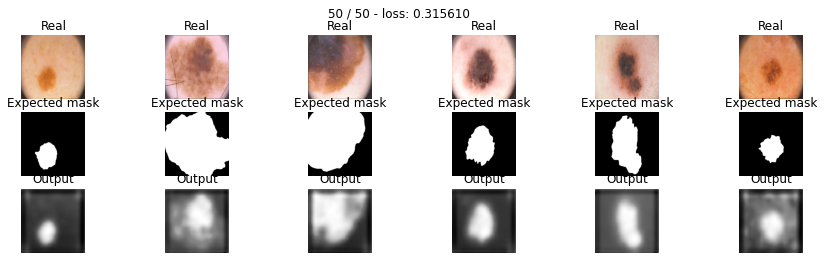

In [ ]:
max_epochs = 50
opt = torch.optim.Adam(model.parameters())
train(model, opt, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_pytorch,data_val)

0.0

-----------------------------------------------------------------------------------------

# U-Net 

[**U-Net**](https://arxiv.org/abs/1505.04597) это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Учитывая медицинское изображение, он выводит изображение в оттенках серого, представляющее вероятность того, что каждый пиксель является интересующей областью.

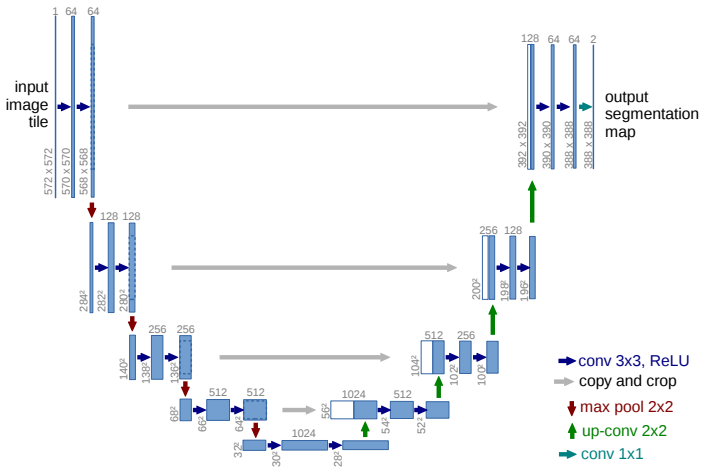

У нас в архитектуре все так же существует енкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются skip-conenctions. Элементы соединяющие части декодера и енкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 8, kernel_size=3, padding=1)
        self.pool0 = nn.MaxPool2d((2, 2))  # 256 -> 128
#         self.bn0 = nn.BatchNorm2d(8)
        self.enc_conv1 = nn.Conv2d(8, 8, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d((2, 2)) # 128 -> 64
#         self.bn1 = nn.BatchNorm2d(8)
        self.enc_conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d((2, 2)) # 64 -> 32
#         self.bn2 = nn.BatchNorm2d(16)
        self.enc_conv3 =nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d((2, 2)) # 32 -> 16
#         self.bn3= nn.BatchNorm2d(16)
        

        # bottleneck
        
        self.bottleneck_conv = nn.Conv2d(16, 16, kernel_size=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1) # 16 -> 32
#         self.bn_d0 = nn.BatchNorm2d(16)
        self.upsample1 = nn.ConvTranspose2d(32, 8, kernel_size=3, stride=2, padding=1)
#         self.bn_d1 = nn.BatchNorm2d(8)
        self.upsample2 = nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1)
#         self.bn_d2 = nn.BatchNorm2d(8)
        self.upsample3 = nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = self.bottleneck_conv(e3)

#         # decoder
        b = torch.cat([b, e3], axis=1)
        d0 = F.relu(self.upsample0(b, output_size=(32, 32)))
        d0 = torch.cat([d0, e2], axis=1)
        d1 = F.relu(self.upsample1(d0, output_size=(64, 64)))
        d1 = torch.cat([d1, e1], axis=1)
        d2 = F.relu(self.upsample2(d1, output_size=(128, 128)))
        d2 = torch.cat([d2, e0], axis=1)
        d3 = self.upsample3(d2, output_size=(256, 256)) # no activation
        return d3

In [ ]:
unet_model = UNet().to(device)

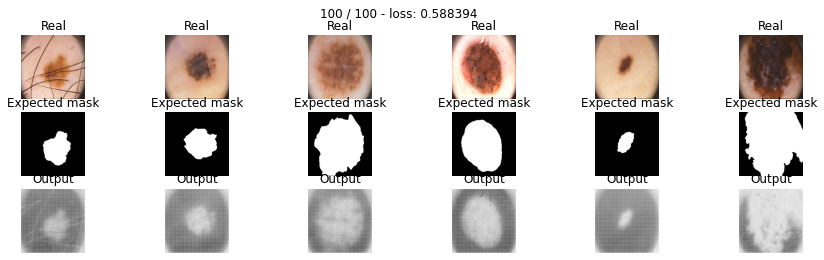

In [ ]:
train(unet_model, optim.Adam(unet_model.parameters(), lr=1e-4), bce_loss, 100, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.0

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Заменим max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):


In [ ]:
unet2_model = UNet2().to(device)


In [ ]:
train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 5, data_tr, data_val)